In [1]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("/Users/jiangliwen/Desktop/MLAI/start_up.csv",encoding= 'ISO-8859-1')
df = df.rename(columns={' market ': "market", ' funding_total_usd ': "funding_total_usd"})
print(df.columns)

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')


# Data Cleaning

In [3]:
# the funding total column is read as a object so clearning it up so that we can use it as a numerical column
df['funding_total_usd']=df['funding_total_usd'].str.replace(',','') # removing commas from funding_total_usd column
df['funding_total_usd']=df['funding_total_usd'].str.replace(' ','')#removing extra space from funding_total_usd column
df['funding_total_usd']=df['funding_total_usd'].str.replace('-','0') #removing - from funding_total_usd column and replacing with 0
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'],errors='coerce')# turning column to number

In [4]:
#turning all date columns in to date
df['founded_at'] =  pd.to_datetime(df['founded_at'], format='%Y-%m-%d', errors = 'coerce') # conveting column into date and ignoring errors
df['first_funding_at'] =  pd.to_datetime(df['first_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['last_funding_at'] =  pd.to_datetime(df['last_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['founded_year'] =  pd.to_datetime(df['founded_year'], format='%Y', errors = 'coerce') # conveting column into date and ignoring errors
df['founded_month'] =  pd.to_datetime(df['founded_month'], format='%Y-%m', errors = 'coerce') # conveting column into date and ignoring errors

df['market'] = df['market'].str.strip() #removing space from beginnning and end of market column

# Feature Engineering

In [5]:
#dropping unecessary columns that I dont plan on using
df = df.drop(columns= ['permalink','homepage_url','state_code','category_list','founded_month', 'founded_quarter','region'])

df = df.dropna(subset=[ 'status', 'name', 'market', 'country_code'])

cat_invest = pd.cut(df.funding_total_usd, bins = [-1, 112500, 1400300, 8205200, 40079503000], labels=['low','low_medium','high_medium','high'])
#labeling total investment values as low, low medium, high medium and high based on their descriptive summary.
df.insert(0,'cat_total_investment',cat_invest) # creating new column called cat_total_investment

df['funding_rounds'] = pd.to_numeric(df['funding_rounds'], errors='coerce')  # turning column to number
cat_funding_rounds = pd.cut(df.funding_rounds, bins = [-1, 2, 20], labels=['low','high'])
#labeling funding_rounds as low and high based on their descriptive summary.
df.insert(0,'cat_funding_rounds',cat_funding_rounds)# creating new column called cat_funding_rounds

cat_seed = pd.cut(df.seed, bins = [-1, 28000, 140000000], labels=['low','high'])
#labeling seed as low and high  based on their descriptive summary.
df.insert(0,'cat_seed',cat_seed)# creating new column called cat_seed

cat_venture = pd.cut(df.venture, bins = [-1, 85038.5, 6000000, 2451000000], labels=['low','medium','high'])
#labeling venture as low, medium and high based on their descriptive summary.
df.insert(0,'cat_venture',cat_venture) # creating new column called cat_venture

# fixing the categorical columns  into numerical values so that we can use it on the model
df['cat_status'] = df['status'].replace(['closed', 'operating', 'acquired'], [0, 1, 2])
df['cat_total_investment'] = df['cat_total_investment'].replace(['low','low_medium','high_medium','high'], [0, 1, 2, 3])
df['cat_funding_rounds'] = df['cat_funding_rounds'].replace(['low', 'high'], [0, 1])
df['cat_seed'] = df['cat_seed'].replace(['low', 'high'], [0, 1])
df['cat_venture'] = df['cat_venture'].replace(['low','medium','high'], [0, 1, 3])

#as a lot of the money columns have 0, we are turning them into new categories of 0 and 1
df.loc[df['equity_crowdfunding'] < 1, 'cat_equity_crowdfunding'] = 0
df.loc[df['equity_crowdfunding'] > 1, 'cat_equity_crowdfunding'] = 1
df['cat_equity_crowdfunding'] = df['cat_equity_crowdfunding'].astype('category')

df.loc[df['undisclosed'] < 1, 'cat_undisclosed'] = 0
df.loc[df['undisclosed'] > 1, 'cat_undisclosed'] = 1
df['cat_undisclosed'] = df['cat_undisclosed'].astype('category')

df.loc[df['convertible_note'] < 1, 'cat_convertible_note'] = 0
df.loc[df['convertible_note'] > 1, 'cat_convertible_note'] = 1
df['cat_convertible_note'] = df['cat_convertible_note'].astype('category')

df.loc[df['debt_financing'] < 1, 'cat_debt_financing'] = 0
df.loc[df['debt_financing'] > 1, 'cat_debt_financing'] = 1
df['cat_debt_financing'] = df['cat_debt_financing'].astype('category')

df.loc[df['angel'] < 1, 'cat_angel'] = 0
df.loc[df['angel'] > 1, 'cat_angel'] = 1
df['cat_angel'] = df['cat_angel']. astype('category')

df.loc[df['grant'] < 1, 'cat_grant'] = 0
df.loc[df['grant'] > 1, 'cat_grant'] = 1
df['cat_grant'] = df['cat_grant'].astype('category')

df.loc[df['private_equity'] < 1, 'cat_private_equity'] = 0
df.loc[df['private_equity'] > 1, 'cat_private_equity'] = 1
df['cat_private_equity'] = df['cat_private_equity'].astype('category')

df.loc[df['post_ipo_equity'] < 1, 'cat_post_ipo_equity'] = 0
df.loc[df['post_ipo_equity'] > 1, 'cat_post_ipo_equity'] = 1
df['cat_post_ipo_equity'] = df['cat_post_ipo_equity'].astype('category')

df.loc[df['post_ipo_debt'] < 1, 'cat_post_ipo_debt'] = 0
df.loc[df['post_ipo_debt'] > 1, 'cat_post_ipo_debt'] = 1
df['cat_post_ipo_debt'] = df['cat_post_ipo_debt'].astype('category')


df.loc[df['product_crowdfunding'] < 1, 'cat_product_crowdfunding'] = 0
df.loc[df['product_crowdfunding'] > 1, 'cat_product_crowdfunding'] = 1
df['cat_product_crowdfunding'] = df['cat_product_crowdfunding'].astype('category')

In [6]:
# counrtry level comparison
country = pd.read_csv('/Users/jiangliwen/Desktop/MLAI/country.csv') # uploading dataset to map countyr code to continent
country = country[['alpha-3','region','sub-region','region-code','sub-region-code']]
country = country.dropna(how='any',axis=0)
country.isnull().sum() # checking if there is null values
df1 = df.merge(country, left_on='country_code', right_on='alpha-3')
df1['sub_region'] = df1['sub-region'].astype('category')
label_encoder = LabelEncoder()
df1['sub_region_cat'] = label_encoder.fit_transform(df1['sub_region'])

category_mapping_region = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

df1.head()

,cat_venture,cat_seed,cat_funding_rounds,cat_total_investment,name,market,funding_total_usd,status,country_code,city,...,cat_post_ipo_equity,cat_post_ipo_debt,cat_product_crowdfunding,alpha-3,region,sub-region,region-code,sub-region-code,sub_region,sub_region_cat
0,0,1,0,2,#waywire,News,1750000.0,acquired,USA,New York,...,0.0,0.0,0.0,USA,Americas,Northern America,19.0,21.0,Northern America,6
1,1,0,0,2,&TV Communications,Games,4000000.0,operating,USA,Los Angeles,...,0.0,0.0,0.0,USA,Americas,Northern America,19.0,21.0,Northern America,6
2,0,0,0,0,-R- Ranch and Mine,Tourism,60000.0,operating,USA,Fort Worth,...,0.0,0.0,0.0,USA,Americas,Northern America,19.0,21.0,Northern America,6
3,0,0,0,0,004 Technologies,Software,0.0,operating,USA,Champaign,...,0.0,0.0,0.0,USA,Americas,Northern America,19.0,21.0,Northern America,6
4,0,0,0,0,1-4 All,Software,0.0,operating,USA,Connellys Springs,...,0.0,0.0,0.0,USA,Americas,Northern America,19.0,21.0,Northern America,6


In [7]:
# grouping markets in industries to decrease the number of segments. The list was being taken from here https://support.crunchbase.com/hc/en-us/articles/360043146954-What-Industries-are-included-in-Crunchbase-
admin_services = str('Employer Benefits Programs, Human Resource Automation, Corporate IT, Distribution, Service Providers, Archiving Service, Call Center, Collection Agency, College Recruiting, Courier Service, Debt Collections, Delivery, Document Preparation, Employee Benefits, Extermination Service, Facilities Support Services, Housekeeping Service, Human Resources, Knowledge Management, Office Administration, Packaging Services, Physical Security, Project Management, Staffing Agency, Trade Shows, Virtual Workforce').split(', ')
advertising = str('Creative Industries, Promotional, Advertising Ad Exchange, Ad Network, Ad Retargeting, Ad Server, Ad Targeting, Advertising, Advertising Platforms, Affiliate Marketing, Local Advertising, Mobile Advertising, Outdoor Advertising, SEM, Social Media Advertising, Video Advertising').split(', ')
agriculture = str('Agriculture, AgTech, Animal Feed, Aquaculture, Equestrian, Farming, Forestry, Horticulture, Hydroponics, Livestock').split(', ')
app = str('Application Performance Monitoring, App Stores, Application Platforms, Enterprise Application, App Discovery, Apps, Consumer Applications, Enterprise Applications, Mobile Apps, Reading Apps, Web Apps').split(', ')
artificial_intelli = str('Artificial Intelligence, Intelligent Systems, Machine Learning, Natural Language Processing, Predictive Analytics').split(', ')
biotechnology = str('Synthetic Biology, Bio-Pharm, Bioinformatics, Biometrics, Biopharma, Biotechnology, Genetics, Life Science, Neuroscience, Quantified Self').split(', ')
clothing = str('Fashion, Laundry and Dry-cleaning, Lingerie, Shoes').split(', ')
shopping = str('Consumer Behavior, Customer Support Tools, Discounts, Reviews and Recommendations, Auctions, Classifieds, Collectibles, Consumer Reviews, Coupons, E-Commerce, E-Commerce Platforms, Flash Sale, Gift, Gift Card, Gift Exchange, Gift Registry, Group Buying, Local Shopping, Made to Order, Marketplace, Online Auctions, Personalization, Point of Sale, Price Comparison, Rental, Retail, Retail Technology, Shopping, Shopping Mall, Social Shopping, Sporting Goods, Vending and Concessions, Virtual Goods, Wholesale').split(', ')
community = str("Self Development, Sex, Forums, Match-Making, Babies, Identity, Women, Kids, Entrepreneur, Networking, Adult, Baby, Cannabis, Children, Communities, Dating, Elderly, Family, Funerals, Humanitarian, Leisure, LGBT, Lifestyle, Men's, Online Forums, Parenting, Pet, Private Social Networking, Professional Networking, Q&A, Religion, Retirement, Sex Industry, Sex Tech, Social, Social Entrepreneurship, Teenagers, Virtual World, Wedding, Women's, Young Adults").split(', ')
electronics  = str('Mac, iPod Touch, Tablets, iPad, iPhone, Computer, Consumer Electronics, Drones, Electronics, Google Glass, Mobile Devices, Nintendo, Playstation, Roku, Smart Home, Wearables, Windows Phone, Xbox').split(', ')
consumer_goods= str('Commodities, Sunglasses, Groceries, Batteries, Cars, Beauty, Comics, Consumer Goods, Cosmetics, DIY, Drones, Eyewear, Fast-Moving Consumer Goods, Flowers, Furniture, Green Consumer Goods, Handmade, Jewelry, Lingerie, Shoes, Tobacco, Toys').split(', ')
content = str('E-Books, MicroBlogging, Opinions, Blogging Platforms, Content Delivery Network, Content Discovery, Content Syndication, Creative Agency, DRM, EBooks, Journalism, News, Photo Editing, Photo Sharing, Photography, Printing, Publishing, Social Bookmarking, Video Editing, Video Streaming').split(', ')
data = str('Optimization, A/B Testing, Analytics, Application Performance Management, Artificial Intelligence, Big Data, Bioinformatics, Biometrics, Business Intelligence, Consumer Research, Data Integration, Data Mining, Data Visualization, Database, Facial Recognition, Geospatial, Image Recognition, Intelligent Systems, Location Based Services, Machine Learning, Market Research, Natural Language Processing, Predictive Analytics, Product Research, Quantified Self, Speech Recognition, Test and Measurement, Text Analytics, Usability Testing').split(', ')
design = str('Visualization, Graphics, Design, Designers, CAD, Consumer Research, Data Visualization, Fashion, Graphic Design, Human Computer Interaction, Industrial Design, Interior Design, Market Research, Mechanical Design, Product Design, Product Research, Usability Testing, UX Design, Web Design').split(', ')
education = str('Universities, College Campuses, University Students, High Schools, All Students, Colleges, Alumni, Charter Schools, College Recruiting, Continuing Education, Corporate Training, E-Learning, EdTech, Education, Edutainment, Higher Education, Language Learning, MOOC, Music Education, Personal Development, Primary Education, Secondary Education, Skill Assessment, STEM Education, Textbook, Training, Tutoring, Vocational Education').split(', ')
energy = str('Gas, Natural Gas Uses, Oil, Oil & Gas, Battery, Biofuel, Biomass Energy, Clean Energy, Electrical Distribution, Energy, Energy Efficiency, Energy Management, Energy Storage, Fossil Fuels, Fuel, Fuel Cell, Oil and Gas, Power Grid, Renewable Energy, Solar, Wind Energy').split(', ')
events = str('Concerts, Event Management, Event Promotion, Events, Nightclubs, Nightlife, Reservations, Ticketing, Wedding').split(', ')
financial = str('Debt Collecting, P2P Money Transfer, Investment Management, Trading, Accounting, Angel Investment, Asset Management, Auto Insurance, Banking, Bitcoin, Commercial Insurance, Commercial Lending, Consumer Lending, Credit, Credit Bureau, Credit Cards, Crowdfunding, Cryptocurrency, Debit Cards, Debt Collections, Finance, Financial Exchanges, Financial Services, FinTech, Fraud Detection, Funding Platform, Gift Card, Health Insurance, Hedge Funds, Impact Investing, Incubators, Insurance, InsurTech, Leasing, Lending, Life Insurance, Micro Lending, Mobile Payments, Payments, Personal Finance, Prediction Markets, Property Insurance, Real Estate Investment, Stock Exchanges, Trading Platform, Transaction Processing, Venture Capital, Virtual Currency, Wealth Management').split(', ')
food = str('Specialty Foods, Bakery, Brewing, Cannabis, Catering, Coffee, Confectionery, Cooking, Craft Beer, Dietary Supplements, Distillery, Farmers Market, Food and Beverage, Food Delivery, Food Processing, Food Trucks, Fruit, Grocery, Nutrition, Organic Food, Recipes, Restaurants, Seafood, Snack Food, Tea, Tobacco, Wine And Spirits, Winery').split(', ')
gaming = str('Game, Games, Casual Games, Console Games, Contests, Fantasy Sports, Gambling, Gamification, Gaming, MMO Games, Online Games, PC Games, Serious Games, Video Games').split(', ')
government = str('Polling, Governance, CivicTech, Government, GovTech, Law Enforcement, Military, National Security, Politics, Public Safety, Social Assistance').split(', ')
hardware= str('Cable, 3D, 3D Technology, Application Specific Integrated Circuit (ASIC), Augmented Reality, Cloud Infrastructure, Communication Hardware, Communications Infrastructure, Computer, Computer Vision, Consumer Electronics, Data Center, Data Center Automation, Data Storage, Drone Management, Drones, DSP, Electronic Design Automation (EDA), Electronics, Embedded Systems, Field-Programmable Gate Array (FPGA), Flash Storage, Google Glass, GPS, GPU, Hardware, Industrial Design, Laser, Lighting, Mechanical Design, Mobile Devices, Network Hardware, NFC, Nintendo, Optical Communication, Playstation, Private Cloud, Retail Technology, RFID, RISC, Robotics, Roku, Satellite Communication, Semiconductor, Sensor, Sex Tech, Telecommunications, Video Conferencing, Virtual Reality, Virtualization, Wearables, Windows Phone, Wireless, Xbox').split(', ')
health_care = str('Senior Health, Physicians, Electronic Health Records, Doctors, Healthcare Services, Diagnostics, Alternative Medicine, Assisted Living, Assistive Technology, Biopharma, Cannabis, Child Care, Clinical Trials, Cosmetic Surgery, Dental, Diabetes, Dietary Supplements, Elder Care, Electronic Health Record (EHR), Emergency Medicine, Employee Benefits, Fertility, First Aid, Funerals, Genetics, Health Care, Health Diagnostics, Home Health Care, Hospital, Medical, Medical Device, mHealth, Nursing and Residential Care, Nutraceutical, Nutrition, Outpatient Care, Personal Health, Pharmaceutical, Psychology, Rehabilitation, Therapeutics, Veterinary, Wellness').split(', ')
it = str('Distributors, Algorithms, ICT, M2M, Technology, Business Information Systems, CivicTech, Cloud Data Services, Cloud Management, Cloud Security, CMS, Contact Management, CRM, Cyber Security, Data Center, Data Center Automation, Data Integration, Data Mining, Data Visualization, Document Management, E-Signature, Email, GovTech, Identity Management, Information and Communications Technology (ICT), Information Services, Information Technology, Intrusion Detection, IT Infrastructure, IT Management, Management Information Systems, Messaging, Military, Network Security, Penetration Testing, Private Cloud, Reputation, Sales Automation, Scheduling, Social CRM, Spam Filtering, Technical Support, Unified Communications, Video Chat, Video Conferencing, Virtualization, VoIP').split(', ')
internet = str('Online Identity, Cyber, Portals, Web Presence Management, Domains, Tracking, Web Tools, Curated Web, Search, Cloud Computing, Cloud Data Services, Cloud Infrastructure, Cloud Management, Cloud Storage, Darknet, Domain Registrar, E-Commerce Platforms, Ediscovery, Email, Internet, Internet of Things, ISP, Location Based Services, Messaging, Music Streaming, Online Forums, Online Portals, Private Cloud, Product Search, Search Engine, SEM, Semantic Search, Semantic Web, SEO, SMS, Social Media, Social Media Management, Social Network, Unified Communications, Vertical Search, Video Chat, Video Conferencing, Visual Search, VoIP, Web Browsers, Web Hosting').split(', ')
invest = str('Angel Investment, Banking, Commercial Lending, Consumer Lending, Credit, Credit Cards, Financial Exchanges, Funding Platform, Hedge Funds, Impact Investing, Incubators, Micro Lending, Stock Exchanges, Trading Platform, Venture Capital').split(', ')
manufacturing = str('Innovation Engineering, Civil Engineers, Heavy Industry, Engineering Firms, Systems, 3D Printing, Advanced Materials, Foundries, Industrial, Industrial Automation, Industrial Engineering, Industrial Manufacturing, Machinery Manufacturing, Manufacturing, Paper Manufacturing, Plastics and Rubber Manufacturing, Textiles, Wood Processing').split(', ')
media = str('Writers, Creative, Television, Entertainment, Media, Advice, Animation, Art, Audio, Audiobooks, Blogging Platforms, Broadcasting, Celebrity, Concerts, Content, Content Creators, Content Discovery, Content Syndication, Creative Agency, Digital Entertainment, Digital Media, DRM, EBooks, Edutainment, Event Management, Event Promotion, Events, Film, Film Distribution, Film Production, Guides, In-Flight Entertainment, Independent Music, Internet Radio, Journalism, Media and Entertainment, Motion Capture, Music, Music Education, Music Label, Music Streaming, Music Venues, Musical Instruments, News, Nightclubs, Nightlife, Performing Arts, Photo Editing, Photo Sharing, Photography, Podcast, Printing, Publishing, Reservations, Social Media, Social News, Theatre, Ticketing, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming, Virtual World').split(', ')
message = str('Unifed Communications, Chat, Email, Meeting Software, Messaging, SMS, Unified Communications, Video Chat, Video Conferencing, VoIP, Wired Telecommunications').split(', ')
mobile = str('Android, Google Glass, iOS, mHealth, Mobile, Mobile Apps, Mobile Devices, Mobile Payments, Windows Phone, Wireless').split(', ')
music = str('Audio, Audiobooks, Independent Music, Internet Radio, Music, Music Education, Music Label, Music Streaming, Musical Instruments, Podcast').split(', ')
resource = str('Biofuel, Biomass Energy, Fossil Fuels, Mineral, Mining, Mining Technology, Natural Resources, Oil and Gas, Precious Metals, Solar, Timber, Water, Wind Energy').split(', ')
navigation = str('Maps, Geospatial, GPS, Indoor Positioning, Location Based Services, Mapping Services, Navigation').split(', ')
other = str('Mass Customization, Monetization, Testing, Subscription Businesses, Mobility, Incentives, Peer-to-Peer, Nonprofits, Alumni, Association, B2B, B2C, Blockchain, Charity, Collaboration, Collaborative Consumption, Commercial, Consumer, Crowdsourcing, Customer Service, Desktop Apps, Emerging Markets, Enterprise, Ethereum, Franchise, Freemium, Generation Y, Generation Z, Homeless Shelter, Infrastructure, Knowledge Management, LGBT Millennials, Non Profit, Peer to Peer, Professional Services, Project Management, Real Time, Retirement, Service Industry, Sharing Economy, Small and Medium Businesses, Social Bookmarking, Social Impact, Subscription Service, Technical Support, Underserved Children, Universities').split(', ')
payment = str('Billing, Bitcoin, Credit Cards, Cryptocurrency, Debit Cards, Fraud Detection, Mobile Payments, Payments, Transaction Processing, Virtual Currency').split(', ')
platforms = str('Development Platforms, Android, Facebook, Google, Google Glass, iOS, Linux, macOS, Nintendo, Operating Systems, Playstation, Roku, Tizen, Twitter, WebOS, Windows, Windows Phone, Xbox').split(', ')
privacy = str('Digital Rights Management, Personal Data, Cloud Security, Corrections Facilities, Cyber Security, DRM, E-Signature, Fraud Detection, Homeland Security, Identity Management, Intrusion Detection, Law Enforcement, Network Security, Penetration Testing, Physical Security, Privacy, Security').split(', ')
services = str('Funeral Industry, English-Speaking, Spas, Plumbers, Service Industries, Staffing Firms, Translation, Career Management, Business Services, Services, Accounting, Business Development, Career Planning, Compliance, Consulting, Customer Service, Employment, Environmental Consulting, Field Support, Freelance, Intellectual Property, Innovation Management, Legal, Legal Tech, Management Consulting, Outsourcing, Professional Networking, Quality Assurance, Recruiting, Risk Management, Social Recruiting, Translation Service').split(', ')
realestate= str('Office Space, Self Storage, Brokers, Storage, Home Owners, Self Storage , Realtors, Home & Garden, Utilities, Home Automation, Architecture, Building Maintenance, Building Material, Commercial Real Estate, Construction, Coworking, Facility Management, Fast-Moving Consumer Goods, Green Building, Home and Garden, Home Decor, Home Improvement, Home Renovation, Home Services, Interior Design, Janitorial Service, Landscaping, Property Development, Property Management, Real Estate, Real Estate Investment, Rental Property, Residential, Self-Storage, Smart Building, Smart Cities, Smart Home, Timeshare, Vacation Rental').split(', ')
sales = str('Advertising, Affiliate Marketing, App Discovery, App Marketing, Brand Marketing, Cause Marketing, Content Marketing, CRM, Digital Marketing, Digital Signage, Direct Marketing, Direct Sales, Email Marketing, Lead Generation, Lead Management, Local, Local Advertising, Local Business, Loyalty Programs, Marketing, Marketing Automation, Mobile Advertising, Multi-level Marketing, Outdoor Advertising, Personal Branding, Public Relations, Sales, Sales Automation, SEM, SEO, Social CRM, Social Media Advertising, Social Media Management, Social Media Marketing, Sponsorship, Video Advertising').split(', ')
science = str('Face Recognition, New Technologies, Advanced Materials, Aerospace, Artificial Intelligence, Bioinformatics, Biometrics, Biopharma, Biotechnology, Chemical, Chemical Engineering, Civil Engineering, Embedded Systems, Environmental Engineering, Human Computer Interaction, Industrial Automation, Industrial Engineering, Intelligent Systems, Laser, Life Science, Marine Technology, Mechanical Engineering, Nanotechnology, Neuroscience, Nuclear, Quantum Computing, Robotics, Semiconductor, Software Engineering, STEM Education').split(', ')
software = str('Business Productivity, 3D Technology, Android, App Discovery, Application Performance Management, Apps, Artificial Intelligence, Augmented Reality, Billing, Bitcoin, Browser Extensions, CAD, Cloud Computing, Cloud Management, CMS, Computer Vision, Consumer Applications, Consumer Software, Contact Management, CRM, Cryptocurrency, Data Center Automation, Data Integration, Data Storage, Data Visualization, Database, Developer APIs, Developer Platform, Developer Tools, Document Management, Drone Management, E-Learning, EdTech, Electronic Design Automation (EDA), Embedded Software, Embedded Systems, Enterprise Applications, Enterprise Resource Planning (ERP), Enterprise Software, Facial Recognition, File Sharing, IaaS, Image Recognition, iOS, Linux, Machine Learning, macOS, Marketing Automation, Meeting Software, Mobile Apps, Mobile Payments, MOOC, Natural Language Processing, Open Source, Operating Systems, PaaS, Predictive Analytics, Presentation Software, Presentations, Private Cloud, Productivity Tools, QR Codes, Reading Apps, Retail Technology, Robotics, SaaS, Sales Automation, Scheduling, Sex Tech, Simulation, SNS, Social CRM, Software, Software Engineering, Speech Recognition, Task Management, Text Analytics, Transaction Processing, Video Conferencing, Virtual Assistant, Virtual Currency, Virtual Desktop, Virtual Goods, Virtual Reality, Virtual World, Virtualization, Web Apps, Web Browsers, Web Development').split(', ')
sports = str('American Football, Baseball, Basketball, Boating, Cricket, Cycling, Diving, eSports, Fantasy Sports, Fitness, Golf, Hockey, Hunting, Outdoors, Racing, Recreation, Rugby, Sailing, Skiing, Soccer, Sporting Goods, Sports, Surfing, Swimming, Table Tennis, Tennis, Ultimate Frisbee, Volley Ball').split(', ')
sustainability = str('Green, Wind, Biomass Power Generation, Renewable Tech, Environmental Innovation, Renewable Energies, Clean Technology, Biofuel, Biomass Energy, Clean Energy, CleanTech, Energy Efficiency, Environmental Engineering, Green Building, Green Consumer Goods, GreenTech, Natural Resources, Organic, Pollution Control, Recycling, Renewable Energy, Solar, Sustainability, Waste Management, Water Purification, Wind Energy').split(', ')
transportation = str('Taxis, Air Transportation, Automotive, Autonomous Vehicles, Car Sharing, Courier Service, Delivery Service, Electric Vehicle, Ferry Service, Fleet Management, Food Delivery, Freight Service, Last Mile Transportation, Limousine Service, Logistics, Marine Transportation, Parking, Ports and Harbors, Procurement, Public Transportation, Railroad, Recreational Vehicles, Ride Sharing, Same Day Delivery, Shipping, Shipping Broker, Space Travel, Supply Chain Management, Taxi Service, Transportation, Warehousing, Water Transportation').split(', ')
travel = str('Adventure Travel, Amusement Park and Arcade, Business Travel, Casino, Hospitality, Hotel, Museums and Historical Sites, Parks, Resorts, Timeshare, Tour Operator, Tourism, Travel, Travel Accommodations, Travel Agency, Vacation Rental').split(', ')
video = str('Animation, Broadcasting, Film, Film Distribution, Film Production, Motion Capture, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming').split(', ')

#Making new column called  Industry group
df1['Industry_Group'] = pd.np.where(df1.market.str.contains('|'.join(admin_services), flags=re.IGNORECASE), "Administrative Services",
                               pd.np.where(df1.market.str.contains('|'.join(software), flags=re.IGNORECASE), "Software",
                               pd.np.where(df1.market.str.contains('|'.join(advertising), flags=re.IGNORECASE), "Advertising",
                               pd.np.where(df1.market.str.contains('|'.join(agriculture), flags=re.IGNORECASE), "Agriculture and Farming",
                               pd.np.where(df1.market.str.contains('|'.join(app), flags=re.IGNORECASE), "Apps",
                               pd.np.where(df1.market.str.contains('|'.join(artificial_intelli), flags=re.IGNORECASE), "Artificial Intelligence",
                               pd.np.where(df1.market.str.contains('|'.join(biotechnology), flags=re.IGNORECASE), "Biotechnology",
                               pd.np.where(df1.market.str.contains('|'.join(clothing), flags=re.IGNORECASE), "Clothing and Apparel",
                               pd.np.where(df1.market.str.contains('|'.join(shopping), flags=re.IGNORECASE), "Commerce and Shopping",
                               pd.np.where(df1.market.str.contains('|'.join(community), flags=re.IGNORECASE), "Community and Lifestyle",
                               pd.np.where(df1.market.str.contains('|'.join(electronics), flags=re.IGNORECASE), "Consumer Electronics",
                               pd.np.where(df1.market.str.contains('|'.join(consumer_goods), flags=re.IGNORECASE), "Consumer Goods",
                               pd.np.where(df1.market.str.contains('|'.join(content), flags=re.IGNORECASE), "Content and Publishing",
                               pd.np.where(df1.market.str.contains('|'.join(data), flags=re.IGNORECASE), "Data and Analytics",
                               pd.np.where(df1.market.str.contains('|'.join(design), flags=re.IGNORECASE), "Design",
                               pd.np.where(df1.market.str.contains('|'.join(education), flags=re.IGNORECASE), "Education",
                               pd.np.where(df1.market.str.contains('|'.join(energy), flags=re.IGNORECASE), "Energy",
                               pd.np.where(df1.market.str.contains('|'.join(events), flags=re.IGNORECASE), "Events",
                               pd.np.where(df1.market.str.contains('|'.join(financial), flags=re.IGNORECASE), "Financial Services",
                               pd.np.where(df1.market.str.contains('|'.join(food), flags=re.IGNORECASE), "Food and Beverage",
                               pd.np.where(df1.market.str.contains('|'.join(gaming), flags=re.IGNORECASE), "Gaming",
                               pd.np.where(df1.market.str.contains('|'.join(government), flags=re.IGNORECASE), "Government and Military",
                               pd.np.where(df1.market.str.contains('|'.join(hardware), flags=re.IGNORECASE), "Hardware",
                               pd.np.where(df1.market.str.contains('|'.join(health_care), flags=re.IGNORECASE), "Health Care",
                               pd.np.where(df1.market.str.contains('|'.join(it), flags=re.IGNORECASE), "Information Technology",
                               pd.np.where(df1.market.str.contains('|'.join(internet), flags=re.IGNORECASE), "Internet Services",
                               pd.np.where(df1.market.str.contains('|'.join(invest), flags=re.IGNORECASE), "Lending and Investments",
                               pd.np.where(df1.market.str.contains('|'.join(manufacturing), flags=re.IGNORECASE), "Manufacturing",
                               pd.np.where(df1.market.str.contains('|'.join(media), flags=re.IGNORECASE), "Media and Entertainment",
                               pd.np.where(df1.market.str.contains('|'.join(message), flags=re.IGNORECASE), "Messaging and Telecommunication",
                               pd.np.where(df1.market.str.contains('|'.join(mobile), flags=re.IGNORECASE), "Mobile",
                               pd.np.where(df1.market.str.contains('|'.join(music), flags=re.IGNORECASE), "Music and Audio",
                               pd.np.where(df1.market.str.contains('|'.join(resource), flags=re.IGNORECASE), "Natural Resources",
                               pd.np.where(df1.market.str.contains('|'.join(navigation), flags=re.IGNORECASE), "Navigation and Mapping",
                               pd.np.where(df1.market.str.contains('|'.join(payment), flags=re.IGNORECASE), "Payments",
                               pd.np.where(df1.market.str.contains('|'.join(platforms), flags=re.IGNORECASE), "Platforms",
                               pd.np.where(df1.market.str.contains('|'.join(privacy), flags=re.IGNORECASE), "Privacy and Security",
                               pd.np.where(df1.market.str.contains('|'.join(services), flags=re.IGNORECASE), "Professional Services",
                               pd.np.where(df1.market.str.contains('|'.join(realestate), flags=re.IGNORECASE), "Real Estate",
                               pd.np.where(df1.market.str.contains('|'.join(sales), flags=re.IGNORECASE), "Sales and Marketing",
                               pd.np.where(df1.market.str.contains('|'.join(science), flags=re.IGNORECASE), "Science and Engineering",
                               pd.np.where(df1.market.str.contains('|'.join(sports), flags=re.IGNORECASE), "Sports",
                               pd.np.where(df1.market.str.contains('|'.join(sustainability), flags=re.IGNORECASE), "Sustainability",
                               pd.np.where(df1.market.str.contains('|'.join(transportation), flags=re.IGNORECASE), "Transportation",
                               pd.np.where(df1.market.str.contains('|'.join(travel), flags=re.IGNORECASE), "Travel and Tourism",
                               pd.np.where(df1.market.str.contains('|'.join(video), flags=re.IGNORECASE), "Video",
                               pd.np.where(df1.market.str.contains('|'.join(other), flags=re.IGNORECASE), "Other",  "Other")))))))))))))))))))))))))))))))))))))))))))))))



In [8]:
df1['Industry_Group'] = df1['Industry_Group'].astype('category')
label_encoder = LabelEncoder()
df1['cat_Industry_Group'] = label_encoder.fit_transform(df1['Industry_Group'])
df1.head()

category_mapping_industry = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Display the mapping
print(category_mapping_industry)

{'Administrative Services': 0, 'Advertising': 1, 'Agriculture and Farming': 2, 'Apps': 3, 'Artificial Intelligence': 4, 'Biotechnology': 5, 'Clothing and Apparel': 6, 'Commerce and Shopping': 7, 'Community and Lifestyle': 8, 'Consumer Electronics': 9, 'Consumer Goods': 10, 'Content and Publishing': 11, 'Data and Analytics': 12, 'Design': 13, 'Education': 14, 'Energy': 15, 'Events': 16, 'Financial Services': 17, 'Food and Beverage': 18, 'Gaming': 19, 'Government and Military': 20, 'Hardware': 21, 'Health Care': 22, 'Information Technology': 23, 'Internet Services': 24, 'Manufacturing': 25, 'Media and Entertainment': 26, 'Messaging and Telecommunication': 27, 'Mobile': 28, 'Natural Resources': 29, 'Navigation and Mapping': 30, 'Other': 31, 'Platforms': 32, 'Privacy and Security': 33, 'Professional Services': 34, 'Real Estate': 35, 'Sales and Marketing': 36, 'Science and Engineering': 37, 'Software': 38, 'Sports': 39, 'Sustainability': 40, 'Transportation': 41, 'Travel and Tourism': 42}


# Variable Selection

In [9]:
df_plot = df1[['sub_region_cat','cat_status','cat_Industry_Group']]
df_plot.head()

,sub_region_cat,cat_status,cat_Industry_Group
0,6,2,11
1,6,1,19
2,6,1,42
3,6,1,38
4,6,1,38


<Figure size 720x432 with 0 Axes>

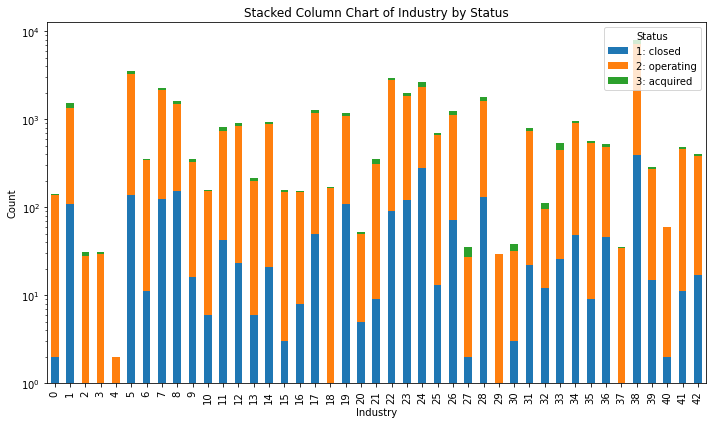

0 : Administrative Services
1 : Advertising
2 : Agriculture and Farming
3 : Apps
4 : Artificial Intelligence
5 : Biotechnology
6 : Clothing and Apparel
7 : Commerce and Shopping
8 : Community and Lifestyle
9 : Consumer Electronics
10 : Consumer Goods
11 : Content and Publishing
12 : Data and Analytics
13 : Design
14 : Education
15 : Energy
16 : Events
17 : Financial Services
18 : Food and Beverage
19 : Gaming
20 : Government and Military
21 : Hardware
22 : Health Care
23 : Information Technology
24 : Internet Services
25 : Manufacturing
26 : Media and Entertainment
27 : Messaging and Telecommunication
28 : Mobile
29 : Natural Resources
30 : Navigation and Mapping
31 : Other
32 : Platforms
33 : Privacy and Security
34 : Professional Services
35 : Real Estate
36 : Sales and Marketing
37 : Science and Engineering
38 : Software
39 : Sports
40 : Sustainability
41 : Transportation
42 : Travel and Tourism


In [10]:
status_dict={'closed': 1, 'operating': 2, 'acquired':3}
# 使用 Seaborn 的 barplot 函数创建分层柱状图
plt.figure(figsize=(10, 6))  # 设置图形尺寸

pivot_df = df_plot.pivot_table(index='cat_Industry_Group', columns='cat_status', aggfunc=len, fill_value=0)

# Create a stacked bar plot using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

pivot_df.plot(kind='bar', stacked=True, ax=ax)
ax.set_yscale('log')  # Set y-axis to logarithmic scale

# Add labels and title
plt.xlabel('Industry')
plt.ylabel('Count')
plt.title('Stacked Column Chart of Industry by Status')

# 显示图例
# Create legend labels using the mapping dictionary
legend_labels = [f'{value}: {key}' for key, value in status_dict.items()]

# Add the legend to the right side of the plot
plt.legend(legend_labels, title='Status', loc='upper right', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()

for key,value in category_mapping_industry.items():
    print(value,":",key)

<Figure size 720x432 with 0 Axes>

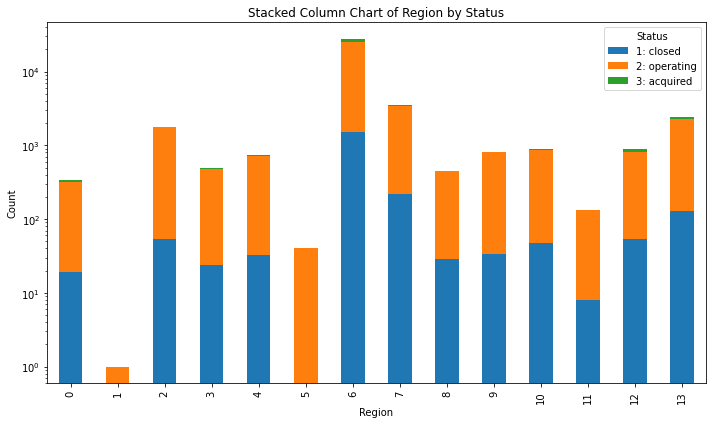

0 : Australia and New Zealand
1 : Central Asia
2 : Eastern Asia
3 : Eastern Europe
4 : Latin America and the Caribbean
5 : Northern Africa
6 : Northern America
7 : Northern Europe
8 : South-eastern Asia
9 : Southern Asia
10 : Southern Europe
11 : Sub-Saharan Africa
12 : Western Asia
13 : Western Europe


In [11]:
plt.figure(figsize=(10, 6))  # 设置图形尺寸

pivot_df = df_plot.pivot_table(index='sub_region_cat', columns='cat_status', aggfunc=len, fill_value=0)

# Create a stacked bar plot using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

pivot_df.plot(kind='bar', stacked=True, ax=ax)
ax.set_yscale('log')  # Set y-axis to logarithmic scale

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Count')
plt.title('Stacked Column Chart of Region by Status')

# 显示图例
# Create legend labels using the mapping dictionary
legend_labels = [f'{value}: {key}' for key, value in status_dict.items()]

# Add the legend to the right side of the plot
plt.legend(legend_labels, title='Status', loc='upper right', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()

for key,value in category_mapping_region.items():
    print(value,":",key)



From the two stacked bar charts above, we can conclude that region and industry group are two important classification feature. However, our dataset contains various features to describe the amount of money attained by various funding rounds, which of them are relatively important features relavent to the final classification of status? Let's do some feature selection work!

In [12]:
df2 = df1[['cat_venture', 'cat_seed',
       'cat_funding_rounds', 'cat_total_investment',
        'cat_status','cat_equity_crowdfunding','cat_undisclosed', 'cat_convertible_note',
       'cat_debt_financing', 'cat_angel', 'cat_grant', 'cat_private_equity',
       'cat_post_ipo_equity', 'cat_post_ipo_debt',
       'cat_product_crowdfunding']]
df2.dropna(inplace=True)

df2.head()

,cat_venture,cat_seed,cat_funding_rounds,cat_total_investment,cat_status,cat_equity_crowdfunding,cat_undisclosed,cat_convertible_note,cat_debt_financing,cat_angel,cat_grant,cat_private_equity,cat_post_ipo_equity,cat_post_ipo_debt,cat_product_crowdfunding
0,0,1,0,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
Y = df2.cat_status
Y = label_encoder.fit_transform(Y)
#print(Y.dtypes)
X = df2.drop('cat_status', axis = 1) #setting features
#print(X.dtypes)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)# test and train dataset


rfc = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfc.fit(X_train, Y_train)#training the model
rfc_pred_test = rfc.predict(X_test)
print(classification_report(Y_test, rfc_pred_test, target_names=['Class 1', 'Class 2', 'Class 3'])) # model is overfitting for class2 and bad at fitting 1 and 3


# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_list = list(X.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00       444
     Class 2       0.86      1.00      0.92      6943
     Class 3       0.12      0.00      0.00       682

    accuracy                           0.86      8069
   macro avg       0.33      0.33      0.31      8069
weighted avg       0.75      0.86      0.80      8069

Variable: cat_venture          Importance: 0.29
Variable: cat_total_investment Importance: 0.26
Variable: cat_seed             Importance: 0.09
Variable: cat_funding_rounds   Importance: 0.06
Variable: cat_angel            Importance: 0.06
Variable: cat_debt_financing   Importance: 0.05
Variable: cat_undisclosed      Importance: 0.04
Variable: cat_grant            Importance: 0.04
Variable: cat_private_equity   Importance: 0.03
Variable: cat_equity_crowdfunding Importance: 0.02
Variable: cat_convertible_note Importance: 0.02
Variable: cat_post_ipo_equity  Importance: 0.02
Variable: cat_post_ipo_debt    Importanc

According to the ranking of importance, we decide to choose industry type, region, venture investment, total investment, angel investment and the number of funding rounds as features to perform the classification task , which is the columns named Industry_Group, sub_region_code, cat_venture,cat_total_investment, cat_seed, cat_funding_rounds.

# Task1- Classification 

In [15]:
df3 = df1[['cat_Industry_Group','sub_region_cat','cat_venture', 'cat_seed',
       'cat_funding_rounds', 'cat_total_investment',
        'cat_status']]
df3.dropna(inplace=True)
df3.head()

,cat_Industry_Group,sub_region_cat,cat_venture,cat_seed,cat_funding_rounds,cat_total_investment,cat_status
0,11,6,0,1,0,2,2
1,19,6,1,0,0,2,1
2,42,6,0,0,0,0,1
3,38,6,0,0,0,0,1
4,38,6,0,0,0,0,1


In [16]:
print(df3.dtypes)

cat_Industry_Group         int64
sub_region_cat             int64
cat_venture             category
cat_seed                category
cat_funding_rounds      category
cat_total_investment    category
cat_status                object
dtype: object


In [17]:
Y = df3.cat_status
Y = label_encoder.fit_transform(Y)
X = df3.drop('cat_status', axis = 1) #setting features


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)# test and train dataset

rfc = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfc.fit(X_train, Y_train)#training the model
rfc_pred_test = rfc.predict(X_test)
print(classification_report(Y_test, rfc_pred_test, target_names=['Class 1', 'Class 2', 'Class 3'])) # model is overfitting for class2 and bad at fitting 1 and 3


# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_list = list(X.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

              precision    recall  f1-score   support

     Class 1       0.06      0.00      0.00       444
     Class 2       0.86      0.99      0.92      6943
     Class 3       0.15      0.01      0.01       682

    accuracy                           0.86      8069
   macro avg       0.36      0.33      0.31      8069
weighted avg       0.76      0.86      0.80      8069

Variable: cat_Industry_Group   Importance: 0.56
Variable: sub_region_cat       Importance: 0.21
Variable: cat_venture          Importance: 0.08
Variable: cat_total_investment Importance: 0.08
Variable: cat_seed             Importance: 0.03
Variable: cat_funding_rounds   Importance: 0.03


# Task2- PCA

## PCA on all variables 

In [18]:
from sklearn.decomposition import PCA

In [30]:
Y = df2.cat_status
Y = label_encoder.fit_transform(Y)
#print(Y.dtypes)
X = df2.drop('cat_status', axis = 1) #setting features
#print(X.dtypes)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)# test and train dataset

pca = PCA(n_components=0.95, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rfc = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfc.fit(X_train_pca, Y_train)#training the model
rfc_pred_test = rfc.predict(X_test_pca)
print(classification_report(Y_test, rfc_pred_test, target_names=['Class 1', 'Class 2', 'Class 3'])) # model is overfitting for class2 and bad at fitting 1 and 3




              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00       444
     Class 2       0.86      1.00      0.92      6943
     Class 3       0.12      0.00      0.00       682

    accuracy                           0.86      8069
   macro avg       0.33      0.33      0.31      8069
weighted avg       0.75      0.86      0.80      8069



In [31]:
print("X_pca.shape: {}".format(X_train_pca.shape))
print("Principal Components (Loadings):", pca.components_)

X_pca.shape: (32272, 5)
Principal Components (Loadings): [[ 7.40588049e-01 -6.62401823e-02  1.15310914e-01  6.57858387e-01
  -5.73535096e-03 -8.91739006e-04 -4.51852823e-04  2.78905015e-02
  -1.19321370e-02 -2.40681394e-03  1.00384599e-02  2.38231664e-03
   4.50660828e-04 -8.51253649e-04]
 [-5.99618761e-01  3.64784756e-01  8.19250050e-02  6.94206558e-01
  -5.71788367e-03  2.16011769e-02  9.64719941e-03  8.20412866e-02
   7.33771392e-02  2.84034312e-02  7.07294156e-02  1.43656811e-02
   4.87012122e-03  2.85034850e-03]
 [ 2.42089000e-01  8.32800042e-01  4.11663206e-01 -2.57224719e-01
  -1.24212991e-02 -2.17369455e-02  2.65555832e-03 -7.20905229e-02
  -2.08232732e-02 -2.24165414e-02 -7.21976957e-02 -1.37704639e-02
  -4.69838912e-03 -3.82856982e-03]
 [-9.79752857e-02 -3.32951482e-01  7.84662590e-01 -7.98744832e-02
   7.92864947e-03  2.11687029e-02  2.68770522e-02  4.88819266e-01
   1.16026278e-01  3.89148498e-02  4.69698910e-02  9.28488200e-03
   2.83477567e-03  3.78606899e-03]
 [-4.537301

In [32]:
print("特征所占百分比:{}".format(sum(pca.explained_variance_ratio_)))

特征所占百分比:0.9549507150837337


In [33]:
print("每个特征所占百分比",pca.explained_variance_ratio_)

每个特征所占百分比 [0.74842046 0.09616604 0.05016638 0.03827788 0.02191995]


In [34]:
print("降维后方差损失:{}".format(1 - pca.explained_variance_ratio_.sum()))

降维后方差损失:0.04504928491626625


## PCA on variables been selected by Random Forest

In [35]:
Y = df3.cat_status
Y = label_encoder.fit_transform(Y)
X = df3.drop('cat_status', axis = 1) #setting features
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)# test and train dataset

pca = PCA(n_components=0.95, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rfc = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfc.fit(X_train_pca, Y_train)#training the model
rfc_pred_test = rfc.predict(X_test_pca)
print(classification_report(Y_test, rfc_pred_test, target_names=['Class 1', 'Class 2', 'Class 3'])) # model is overfitting for class2 and bad at fitting 1 and 3




              precision    recall  f1-score   support

     Class 1       0.06      0.00      0.00       444
     Class 2       0.86      0.99      0.92      6943
     Class 3       0.12      0.01      0.01       682

    accuracy                           0.86      8069
   macro avg       0.35      0.33      0.31      8069
weighted avg       0.75      0.86      0.79      8069



In [36]:
print("X_pca.shape: {}".format(X_train_pca.shape))
pca.components_

X_pca.shape: (32272, 2)


array([[-9.99986360e-01, -1.57427735e-03,  3.21866883e-03,
        -2.38421385e-04,  9.20216575e-04,  3.67931521e-03],
       [ 1.86293705e-03, -9.98237540e-01,  4.47398109e-02,
        -4.31753588e-03,  1.21900690e-02,  3.67349237e-02]])

In [37]:
print("特征所占百分比:{}".format(sum(pca.explained_variance_ratio_)))

特征所占百分比:0.9809914653306805


In [38]:
print("每个特征所占百分比",pca.explained_variance_ratio_)

每个特征所占百分比 [0.94783255 0.03315892]


In [39]:
print("降维后方差损失:{}".format(1 - pca.explained_variance_ratio_.sum()))

降维后方差损失:0.01900853466931951


In [40]:
print("Principal Components (Loadings):", pca.components_)

Principal Components (Loadings): [[-9.99986360e-01 -1.57427735e-03  3.21866883e-03 -2.38421385e-04
   9.20216575e-04  3.67931521e-03]
 [ 1.86293705e-03 -9.98237540e-01  4.47398109e-02 -4.31753588e-03
   1.21900690e-02  3.67349237e-02]]
